In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import gc

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Embedding
from sklearn.model_selection import train_test_split 
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow.python.client import device_lib
from transformers import AutoTokenizer, TFBertModel

SEED = 10

In [2]:
df_fake = pd.read_csv(r'D:\data science\Fake.csv')
df_fake['label'] = 0
df_true = pd.read_csv(r'D:\data science\True.csv')
df_true['label'] = 1

df = pd.concat([df_fake, df_true])
df.dropna(subset = ['text', 'title'], inplace = True)
df['text'] = df['title'] + ' ' + df['text']

X = df['text']
y = df['label']

Text(0.5, 1.0, 'Real  News Subject')

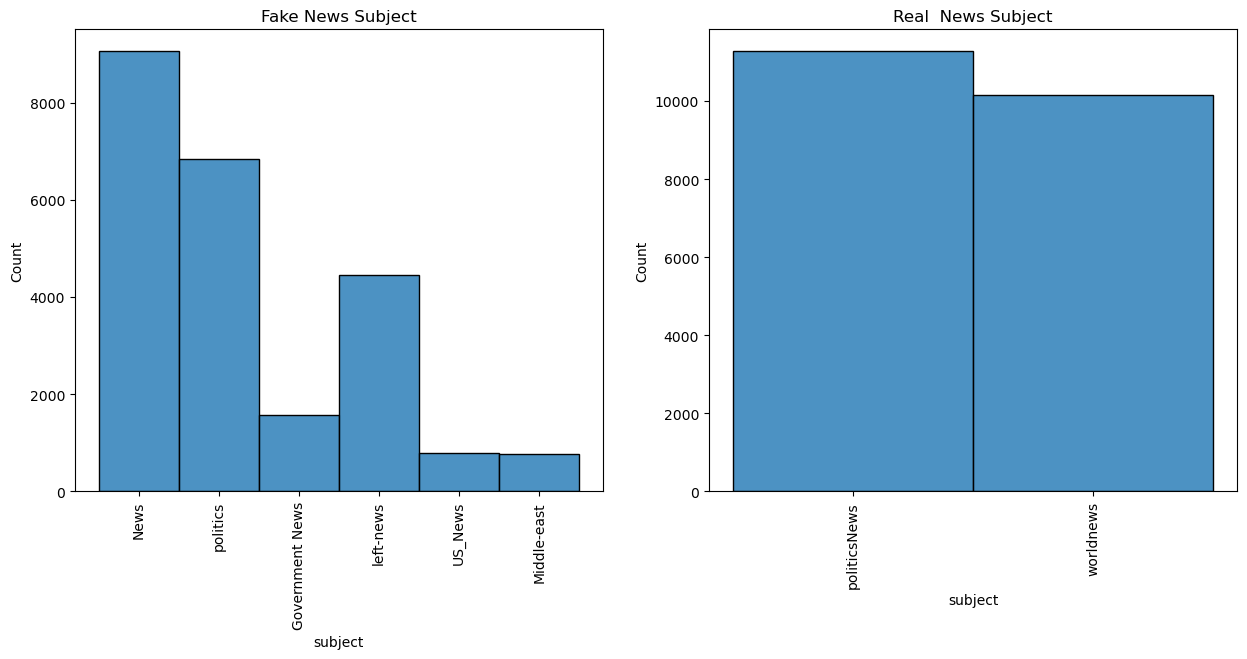

In [3]:
fig, axes = plt.subplots(1,2, figsize = (15,6))
sns.histplot(df_fake.subject, palette = 'Set1', alpha = 0.8, ax = axes[0])
axes[0].tick_params(axis = 'x', rotation = 90)
axes[0].set_title('Fake News Subject')
sns.histplot(df_true.subject, palette = 'Set1', alpha = 0.8, ax = axes[1])
axes[1].tick_params(axis = 'x', rotation = 90)
axes[1].set_title('Real  News Subject')

In [4]:
df['num_words'] = df['text'].apply(lambda x: len(x.split()))

Text(0.5, 1.0, 'Distribution of Fake - 0 /Real - 1 News')

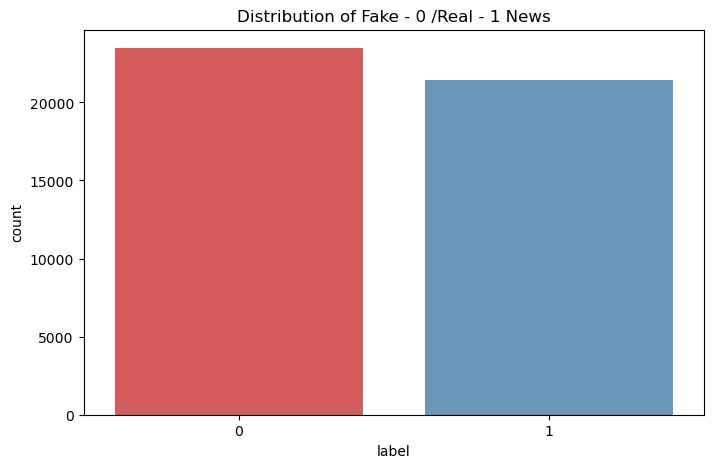

In [5]:
plt.figure(figsize = (8,5))
sns.countplot(x = df['label'], palette = 'Set1', alpha = 0.8)
plt.title('Distribution of Fake - 0 /Real - 1 News')

Text(0.5, 1.0, 'Distribution of the News Words count')

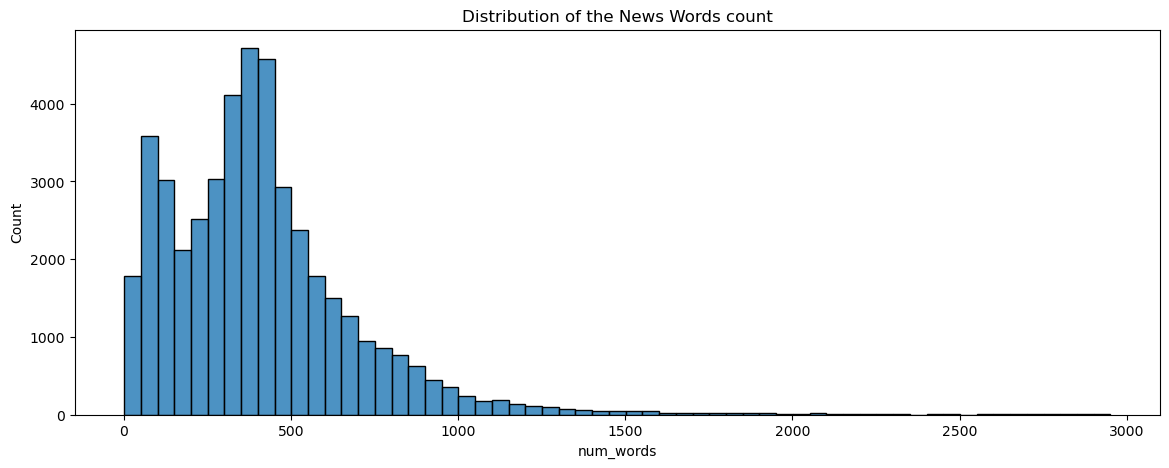

In [6]:
plt.figure(figsize = (14,5))
sns.histplot(df['num_words'], bins = range(1, 3000, 50), palette = 'Set1', alpha = 0.8)
plt.title('Distribution of the News Words count')

In [7]:
MAX_LEN=100
def get_model():
    dropout_rate = 0.2

    input_ids = Input(shape = (MAX_LEN,), dtype = tf.int32, name = 'input_ids')
    input_mask = Input(shape = (MAX_LEN,), dtype = tf.int32, name = 'input_mask')

    embeddings = bert([input_ids, input_mask])[1] #pooler output
    print(embeddings)

    out = Dropout(0.2)(embeddings)
    
    #64 units dense layer
    out = Dense(64,activation = 'relu')(out)
    out = Dropout(0.2)(out)

    y = Dense(1,activation = 'sigmoid')(out)
    
    model = Model(inputs=[input_ids, input_mask], outputs=y)
    model.layers[2].trainable = True
    
    #define optimizer
    optimizer = Adam(learning_rate=1e-05, epsilon=1e-08,decay=0.01,clipnorm=1.0)
    
    #complile the model
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')
    
    return model

#defining tokenization function
def get_tokens(X):
    
    X = tokenizer(
                text = list(X),
                add_special_tokens = True,
                max_length = MAX_LEN,
                truncation = True,
                padding = 'max_length',
                return_tensors = 'tf',
                return_token_type_ids = False,
                return_attention_mask = True,
                verbose = True
                )
    
    return X

In [11]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('bert-base-uncased')

model = get_model()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf_bert_model_1/bert/pooler/dense/Tanh:0', description="created by layer 'tf_bert_model_1'")


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = SEED)

In [ ]:
X_train_seq = get_tokens(X_train)
X_test_seq = get_tokens(X_test)

history = model.fit(x = {'input_ids':X_train_seq['input_ids'],'input_mask':X_train_seq['attention_mask']}, 
                    y = y_train, epochs=3,
                    validation_split = 0.2, batch_size = 32, callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])

Epoch 1/3
  4/898 [..............................] - ETA: 4:44:54 - loss: 0.8418 - accuracy: 0.4766

In [ ]:
def plot_graphs(history, metric):
    
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')ef plot_graphs(history, metric):
    
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [ ]:
yhat =  np.where(model.predict({'input_ids':X_test_seq['input_ids'],'input_mask':X_test_seq['attention_mask']}) >=0.5,1,0)

In [ ]:
print(classification_report(y_test,yhat))

In [ ]:
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test,yhat), annot=True, 
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

In [ ]:
news = ['''Electrion Interference: Zuck Tells Rogan Facebook Censored Hunter Laptop Story After FBI Request. Meta CEO Mark Zuckerberg revealed on Thursday that the FBI warned Facebook about "Russian propaganda" shortly before the Hunter Biden laptop story broke at the NY Post.''']
test_news = get_tokens(news)

model.predict({'input_ids':test_news['input_ids'],'input_mask':test_news['attention_mask']})